# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics for the two artists you selected in Module 1 and the Twitter descriptions pulled for Robyn and Cher. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd

# !pip install wordcloud

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [19]:
# Use this space for any additional import statements you need



In [2]:
# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+$")

# A full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens=5, verbose=True):
    """
    Given a list of tokens, print number of tokens, number of unique tokens, 
    number of characters, lexical diversity, and num_tokens most common tokens. 
    Returns a dictionary of statistics.
    """
    # Total number of tokens
    num_total_tokens = len(tokens)
    
    # Number of unique tokens
    num_unique_tokens = len(set(tokens))
    
    # Number of characters in all tokens
    num_characters = sum(len(token) for token in tokens)
    
    # Lexical diversity (unique tokens / total tokens)
    lexical_diversity = num_unique_tokens / num_total_tokens if num_total_tokens > 0 else 0
    
    # Most common tokens
    token_counts = Counter(tokens).most_common(num_tokens)
    
    # Print statistics if verbose
    if verbose:
        print(f"Total tokens: {num_total_tokens}")
        print(f"Unique tokens: {num_unique_tokens}")
        print(f"Total characters: {num_characters}")
        print(f"Lexical diversity: {lexical_diversity:.4f}")
        print(f"Most common tokens: {token_counts}")
    
    # Return statistics as a dictionary
    return {
        'total_tokens': num_total_tokens,
        'unique_tokens': num_unique_tokens,
        'total_characters': num_characters,
        'lexical_diversity': lexical_diversity,
        'most_common_tokens': token_counts
    }

def contains_emoji(s):
    """
    Checks if the string contains any emoji.
    """
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]
    return len(emojis) > 0

def remove_stop(tokens):
    """
    Removes stopwords from the list of tokens.
    """
    return [token for token in tokens if token.lower() not in sw]

def remove_punctuation(text, punct_set=tw_punct):
    """
    Removes punctuation from the text based on the provided punctuation set.
    """
    return "".join([ch for ch in text if ch not in punct_set])

def tokenize(text):
    """
    Splits the text into tokens, preserving important tokens like hashtags and numbers.
    """
    text = remove_punctuation(text)
    tokens = whitespace_pattern.split(text)  # Split on whitespace
    return [token for token in tokens if token]  # Remove empty strings

def prepare(text, pipeline):
    """
    Applies a list of transformations (pipeline) to the text in sequence.
    """
    tokens = str(text)
    
    for transform in pipeline:
        tokens = transform(tokens)
        
    return tokens


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [3]:

# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "/users/bista/OneDrive/Desktop/Desktop/ADS 509 Applied Text Mining/Assignment 2/" # change to your location if it is not in the same directory as your notebook
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}

In [4]:

twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [5]:


twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [6]:

# LYRICS DATA

# Define the path to the lyrics data folder
lyrics_folder = data_location + "lyrics/"

# Define a dictionary with artist names and their folder paths
artist_folders = {
    'cher': 'cher/',
    'robyn': 'robyn/'
}

# Create an empty list to store lyrics data
lyrics_data = []

# Loop through each artist and their folder
for artist, folder in artist_folders.items():
    folder_path = os.path.join(lyrics_folder, folder)
    
    # Loop through each file in the artist's folder
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        
        # Read the lyrics from the text file
        with open(file_path, 'r', encoding='utf-8') as f:
            lyrics = f.read()
            lyrics_data.append({'artist': artist, 'lyrics': lyrics})

# Convert the list to a DataFrame
lyrics_data = pd.DataFrame(lyrics_data)

# Now apply the pipeline to the lyrics data
lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare, pipeline=[str.lower,
                                                                        remove_punctuation, tokenize, remove_stop])
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len)

# View a sample of the lyrics data after processing
print(lyrics_data.head())


  artist                                             lyrics  \
0   cher  "88 Degrees"\n\n\n\nStuck in L.A., ain't got n...   
1   cher  "A Different Kind Of Love Song"\n\n\n\nWhat if...   
2   cher  "After All"\n\n\n\nWell, here we are again\nI ...   
3   cher  "Again"\n\n\n\nAgain evening finds me at your ...   
4   cher  "Alfie"\n\n\n\nWhat's it all about, Alfie?\nIs...   

                                              tokens  num_tokens  
0  [88, degrees, stuck, la, aint, got, friends, h...         182  
1  [different, kind, love, song, world, crazy, sa...         137  
2  [well, guess, must, fate, weve, tried, deep, i...         120  
3  [evening, finds, door, ask, could, try, dont, ...          34  
4  [alfie, whats, alfie, moment, live, whats, sor...          67  


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [7]:
###
# FOR TWITTER DATA AND LYRICAL DATA.

import os
import re
import pandas as pd
import emoji
from nltk.corpus import stopwords
from string import punctuation

# Punctuation and stopwords settings
punctuation = set(punctuation) - {"#"}  # Keeping hashtags for Twitter
sw = set(stopwords.words("english"))  # English stopwords

# Define the pipeline functions
def remove_punctuation(text, punct_set=punctuation):
    """
    Removes punctuation from the text.
    """
    return "".join([ch for ch in text if ch not in punct_set])

def tokenize(text):
    """
    Tokenizes the text by splitting on whitespace.
    """
    return re.split(r"\s+", text)

def remove_stop(tokens):
    """
    Removes stopwords from a list of tokens.
    """
    return [token for token in tokens if token.lower() not in sw]

def remove_empty(tokens):
    return [token for token in tokens if token.strip()]

def contains_emoji(s):
    """
    Checks if the string contains any emoji.
    """
    emojis = [ch for ch in str(s) if emoji.is_emoji(ch)]
    return len(emojis) > 0

def prepare(text, pipeline):
    """
    Apply a list of transformations (pipeline) to the text sequentially.
    Converts non-string input to an empty string.
    """
    if not isinstance(text, str):
        text = ""  # Handle non-string values, like NaN or float
    for transform in pipeline:
        text = transform(text)
    return text

# lyrics data 
twitter_data["tokens"] = twitter_data["description"].apply(prepare, pipeline=[str.lower, remove_punctuation,
                                                                               tokenize, remove_stop, remove_empty])
twitter_data["num_tokens"] = twitter_data["tokens"].map(len)

# Apply pipeline to lyrics data 
lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare, pipeline=[str.lower, remove_punctuation,
                                                                        tokenize, remove_stop,remove_empty])
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len)

# emoji detection in Twitter data
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

# Display sample of data with emojis
print(twitter_data[twitter_data.has_emoji].sample(10)[["artist", "description", "tokens"]])


        artist                                        description  \
612016    cher  Internationally Published Model ☠️Pirate for l...   
67064     cher  ...though I fall, I will rise. Though I sit in...   
876862    cher  📺 Actor on @911lonestar @queensugarown @sho_th...   
3565304   cher  One Direction have shown me to follow my dream...   
797380    cher                    so I was like ...whatever 🤷🏼‍♀️   
2444568   cher  📖 Asesor en leyes. 🗣️ Asesor en proyectos. 🇨🇴 ...   
405197    cher  Now: @DHSgov Past: @GeorgiaDemocrat, @JoeBiden...   
1785135   cher                        peace, love & dirty beats 🌸   
2073963   cher  Child of God and proud of it❣❣❣ The pic is my ...   
956913    cher                          siempre cansada y que ✌🏽😴   

                                                    tokens  
612016   [internationally, published, model, ☠️pirate, ...  
67064    [though, fall, rise, though, sit, darkness, lo...  
876862   [📺, actor, 911lonestar, queensugarown, shothel..

In [8]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [9]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
1204146,cher,♑️🏳️‍🌈,[♑️🏳️‍🌈]
909813,cher,"Ingénieur, rationaliste et cartésien #CogitoEr...","[ingénieur, rationaliste, et, cartésien, #cogi..."
43586,cher,"The reds, eclectic with the tunes, sober, vega...","[reds, eclectic, tunes, sober, vegan, 🐖, 🌏, in..."
592439,cher,Resale | Presale | Unique ✨I grow investors po...,"[resale, presale, unique, ✨i, grow, investors,..."
2989714,cher,Junior Doctor 💚 MWinS representative - Interes...,"[junior, doctor, 💚, mwins, representative, int..."
426832,cher,"married 🏳️‍🌈 ,Democrat, love music. sports. re...","[married, 🏳️‍🌈, democrat, love, music, sports,..."
1842489,cher,"lover, fighter, and friend.😎 {she/her} phd stu...","[lover, fighter, friend😎, sheher, phd, student..."
307567,cher,☺️💝✨♈️ he/him #blacklivesmatter #blacktransliv...,"[☺️💝✨♈️, hehim, #blacklivesmatter, #blacktrans..."
1973790,cher,People say that nobody's perfect but they obvi...,"[people, say, nobodys, perfect, obviously, hav..."
585658,cher,do whatever makes you happy.✨,"[whatever, makes, happy✨]"


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: One of the area of the improvement to this toeknization would be implementation of lemmatization. Using lemmatization, we would create lemma considering the context and meaning of the words. Lemma has a meaning during the analysis. This provides the text analysis more funcationality, imparts quality and accuray of the results. Also, we could have handle special character and emoji on the twitter data in a better way byt using sentiment analysis. 

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [10]:
###

from collections import Counter

def descriptive_stats(tokens_list, num_tokens=10):
    """
    Given a list of tokenized songs (tokens_list), calculate and return descriptive statistics.
    """
    # Flatten the list of tokens into a single list
    all_tokens = [token for tokens in tokens_list for token in tokens]
    
    # Total number of tokens
    total_tokens = len(all_tokens)
    
    # Number of unique tokens
    unique_tokens = len(set(all_tokens))
    
    # Lexical diversity: unique tokens / total tokens
    lexical_diversity = unique_tokens / total_tokens if total_tokens > 0 else 0
    
    # Most common tokens
    token_counts = Counter(all_tokens)
    most_common_tokens = token_counts.most_common(num_tokens)
    
    # Return all calculated statistics
    return {
        "total_tokens": total_tokens,
        "unique_tokens": unique_tokens,
        "lexical_diversity": lexical_diversity,
        "most_common_tokens": most_common_tokens
    }

# Group by artist and calculate descriptive statistics for each group
artist_groups = lyrics_data.groupby('artist')['tokens'].apply(list)

# Calculate stats for each artist
cher_stats = descriptive_stats(artist_groups['cher'])
robyn_stats = descriptive_stats(artist_groups['robyn'])

# Display the results
print("Cher Lyrics Statistics:")
for key, value in cher_stats.items():
    print(f"{key}: {value}")

print("\nRobyn Lyrics Statistics:")
for key, value in robyn_stats.items():
    print(f"{key}: {value}")


Cher Lyrics Statistics:
total_tokens: 35916
unique_tokens: 3703
lexical_diversity: 0.10310168170174852
most_common_tokens: [('love', 1004), ('im', 513), ('know', 486), ('dont', 440), ('youre', 333), ('time', 319), ('baby', 319), ('see', 308), ('oh', 306), ('one', 282)]

Robyn Lyrics Statistics:
total_tokens: 15227
unique_tokens: 2156
lexical_diversity: 0.14159059565245943
most_common_tokens: [('know', 308), ('dont', 301), ('im', 299), ('love', 275), ('got', 251), ('like', 232), ('baby', 222), ('youre', 169), ('never', 155), ('dance', 150)]


Q: what observations do you make about these data? 

A: Based on the above code we could make numerious observation of the two artists Cher and Robyn. The total token, unique token, lexical diversity and most common tokens of two artists are compared. Cher has significnatly high total tokens and higher unique tokens compared to Robyn. The lexical diversity of Robyn is higher than Cher which suggests Robyn lyrics has more varied words vocabulary in her songs. We also observed the most common words for both Cher and Robyn in the songs. 


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [13]:
# debugging part

import os
import re
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
from string import punctuation

# Settings for punctuation and stopwords
punctuation = set(punctuation) - {"#"}  # Keeping hashtags for Twitter
sw = set(stopwords.words("english"))  # English stopwords

# Define the pipeline functions
def remove_punctuation(text, punct_set=punctuation):
    """Removes punctuation from the text."""
    return "".join([ch for ch in text if ch not in punct_set])

def tokenize(text):
    """Tokenizes the text by splitting on whitespace."""
    return re.split(r"\s+", text)

def remove_stop(tokens):
    """Removes stopwords from a list of tokens."""
    return [token for token in tokens if token.lower() not in sw]

def remove_empty(tokens):
    """Removes empty tokens."""
    return [token for token in tokens if token.strip()]

def prepare(text, pipeline):
    """Applies a list of transformations (pipeline) to the text sequentially."""
    if not isinstance(text, str):
        text = ""  # Handle non-string values, like NaN or float
    for transform in pipeline:
        text = transform(text)
    return text

# Apply the pipeline to process Cher and Robyn lyrics
lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare, pipeline=[str.lower, remove_punctuation,
                                                                        tokenize, remove_stop, remove_empty])
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len)

# Separate Cher and Robyn tokens
cher_tokens = lyrics_data[lyrics_data['artist'] == 'cher']['tokens'].explode().tolist()
robyn_tokens = lyrics_data[lyrics_data['artist'] == 'robyn']['tokens'].explode().tolist()

# Count the tokens for Cher and Robyn
cher_token_counts = Counter(cher_tokens)
robyn_token_counts = Counter(robyn_tokens)

# Total tokens in each corpus
cher_total_tokens = sum(cher_token_counts.values())
robyn_total_tokens = sum(robyn_token_counts.values())

# Calculate concentration of tokens (token frequency / total tokens)
cher_concentration = {token: count / cher_total_tokens for token, count in cher_token_counts.items()}
robyn_concentration = {token: count / robyn_total_tokens for token, count in robyn_token_counts.items()}

# Function to calculate concentration ratio
def concentration_ratio(concentration_1, concentration_2, token_counts_1, token_counts_2, n=5):
    ratio = {}
    for token, count in token_counts_1.items():
        # Only consider tokens that appear at least n times in both corpora
        if count >= n and token in token_counts_2 and token_counts_2[token] >= n:
            ratio[token] = concentration_1[token] / concentration_2[token]
    return ratio

# Function to get the top N tokens based on concentration ratio
def top_concentration_tokens(ratio_dict, top_n=10):
    return sorted(ratio_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]

# Calculate concentration ratios for Cher vs. Robyn and vice versa
cher_vs_robyn_ratio = concentration_ratio(cher_concentration, robyn_concentration, 
                                          cher_token_counts, robyn_token_counts, n=5)
robyn_vs_cher_ratio = concentration_ratio(robyn_concentration, cher_concentration, 
                                          robyn_token_counts, cher_token_counts, n=5)

# Get the top 10 tokens for each corpus based on concentration ratios
top_cher_tokens = top_concentration_tokens(cher_vs_robyn_ratio)
top_robyn_tokens = top_concentration_tokens(robyn_vs_cher_ratio)

# Convert to DataFrame for easier viewing
cher_df = pd.DataFrame(top_cher_tokens, columns=['Token', 'Concentration_Ratio'])
robyn_df = pd.DataFrame(top_robyn_tokens, columns=['Token', 'Concentration_Ratio'])

# Display results
print("Top 10 Tokens for Cher:")
print(cher_df)

print("\nTop 10 Tokens for Robyn:")
print(robyn_df)



Top 10 Tokens for Cher:
     Token  Concentration_Ratio
0     walk            10.005491
1     find             9.680453
2   enough             7.813004
3      man             7.525316
4  without             7.461722
5   strong             6.529007
6     live             5.765876
7  believe             5.588583
8    tears             4.833161
9     name             4.409199

Top 10 Tokens for Robyn:
     Token  Concentration_Ratio
0     beat            20.257113
1    dance            14.152230
2     work            11.950772
3     hang            11.203848
4  forgive             7.547856
5    shake             7.076115
6  alright             7.076115
7    party             6.191600
8    space             5.896762
9  pretend             5.896762


In [3]:

import os
import re
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
from string import punctuation

# Load data
data_location = "/users/bista/OneDrive/Desktop/Desktop/ADS 509 Applied Text Mining/Assignment 2/"
twitter_folder = "twitter/"

artist_files = {
    'cher': 'cher_followers_data.txt',
    'robyn': 'robynkonichiwa_followers_data.txt'
}

# Load Twitter data for both artists
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'], sep="\t", quoting=3)
twitter_data['artist'] = "cher"

twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'], sep="\t", quoting=3)
twitter_data_2['artist'] = "robyn"

# Combine data
twitter_data = pd.concat([twitter_data, twitter_data_2])
del(twitter_data_2)

# Settings for punctuation and stopwords
punctuation = set(punctuation) - {"#"}  # Keeping hashtags for Twitter
sw = set(stopwords.words("english"))  # English stopwords

# Define the pipeline functions
def remove_punctuation(text, punct_set=punctuation):
    """Removes punctuation from the text."""
    return "".join([ch for ch in text if ch not in punct_set])

def tokenize(text):
    """Tokenizes the text by splitting on whitespace."""
    return re.split(r"\s+", text)

def remove_stop(tokens):
    """Removes stopwords from a list of tokens."""
    return [token for token in tokens if token.lower() not in sw]

def remove_empty(tokens):
    """Removes empty tokens."""
    return [token for token in tokens if token.strip()]

def prepare(text, pipeline):
    """Applies a list of transformations (pipeline) to the text sequentially."""
    if not isinstance(text, str):
        text = ""  # Handle non-string values, like NaN or float
    for transform in pipeline:
        text = transform(text)
    return text

# Apply the pipeline to process Twitter descriptions
twitter_data["tokens"] = twitter_data["description"].apply(prepare, pipeline=[str.lower, remove_punctuation, 
                                                                              tokenize, remove_stop, remove_empty])
twitter_data["num_tokens"] = twitter_data["tokens"].map(len)

# Separate tokens by artist
twitter_cher_tokens = twitter_data[twitter_data['artist'] == 'cher']['tokens'].explode().tolist()
twitter_robyn_tokens = twitter_data[twitter_data['artist'] == 'robyn']['tokens'].explode().tolist()

# Count the tokens for Twitter data
twitter_cher_token_counts = Counter(twitter_cher_tokens)
twitter_robyn_token_counts = Counter(twitter_robyn_tokens)

# Total tokens in each corpus
twitter_cher_total_tokens = sum(twitter_cher_token_counts.values())
twitter_robyn_total_tokens = sum(twitter_robyn_token_counts.values())

# Calculate concentration of tokens (token frequency / total tokens)
twitter_cher_concentration = {token: count / twitter_cher_total_tokens for token, 
                              count in twitter_cher_token_counts.items()}
twitter_robyn_concentration = {token: count / twitter_robyn_total_tokens for token, 
                               count in twitter_robyn_token_counts.items()}

# Function to calculate concentration ratio
def concentration_ratio(concentration_1, concentration_2, token_counts_1, token_counts_2, n=5):
    ratio = {}
    for token, count in token_counts_1.items():
        # Only consider tokens that appear at least n times in both corpora
        if count >= n and token in token_counts_2 and token_counts_2[token] >= n:
            ratio[token] = concentration_1[token] / concentration_2[token]
    return ratio

# Function to get the top N tokens based on concentration ratio
def top_concentration_tokens(ratio_dict, top_n=10):
    return sorted(ratio_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]

# Calculate concentration ratios for Twitter data
twitter_cher_vs_robyn_ratio = concentration_ratio(twitter_cher_concentration, twitter_robyn_concentration, 
                                                  twitter_cher_token_counts, twitter_robyn_token_counts, n=5)
twitter_robyn_vs_cher_ratio = concentration_ratio(twitter_robyn_concentration, twitter_cher_concentration, 
                                                  twitter_robyn_token_counts, twitter_cher_token_counts, n=5)

# Get the top 10 tokens for each corpus based on concentration ratios
top_twitter_cher_tokens = top_concentration_tokens(twitter_cher_vs_robyn_ratio)
top_twitter_robyn_tokens = top_concentration_tokens(twitter_robyn_vs_cher_ratio)

# Convert to DataFrame for easier viewing
twitter_cher_df = pd.DataFrame(top_twitter_cher_tokens, columns=['Token', 'Concentration_Ratio'])
twitter_robyn_df = pd.DataFrame(top_twitter_robyn_tokens, columns=['Token', 'Concentration_Ratio'])

# Display results
print("Top 10 Tokens for Cher (Twitter):")
print(twitter_cher_df)

print("\nTop 10 Tokens for Robyn (Twitter):")
print(twitter_robyn_df)


Top 10 Tokens for Cher (Twitter):
            Token  Concentration_Ratio
0     grandmother            35.353340
1            #fbr            24.573926
2        resister            24.447227
3       #resister            24.035512
4            nana            23.663489
5          rbsoul            20.585722
6         grandma            19.900528
7  #theresistance            18.901359
8       hiphoprap            17.959982
9             gop            17.329680

Top 10 Tokens for Robyn (Twitter):
      Token  Concentration_Ratio
0    vänner           293.046383
1      bäst           210.228927
2  sveriges           208.105403
3   träning           203.504433
4   brinner           198.701223
5      följ           195.541216
6     gärna           194.978160
7   arbetar           187.256253
8     varje           184.038791
9    familj           180.499584


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: Some of the top tokens for the Cher were walk, find, enough, man, without, strong, live, believe, tears and name. The top tokens such as walk, find, enough, strong, denoted the resilience and strenght in the Cher lyrics. Also, tears and believe included the sentiment in the lyrics whereas name highighted the identity in the lyrics. 

However, top tokens for Robyn were beat, dance, work, hang, forgive, shake, alright, party, space and pretend. The top tokens were very diverse as beat, dance, work and party highlighted the lifestyle and influence of musics. Other words as forgive, hang, pretend denoted the emotional and sentimental aspect in the lyrics. 

For cher twitter, the top words were grandmother,nana, grandama, etc. establishing the family relationtionship and emotional values. For Robyn twitter, the top words were vanner, bast, traning etc. 

I noticed Cher was focused on the strenght and power in lyrics whereas Robyn highlighted the new style and way of lifestyle. Also, they both have a good amount of emotional and sentiamental words on their lyrics. 

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [14]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

Cher Lyrics Wordcloud:


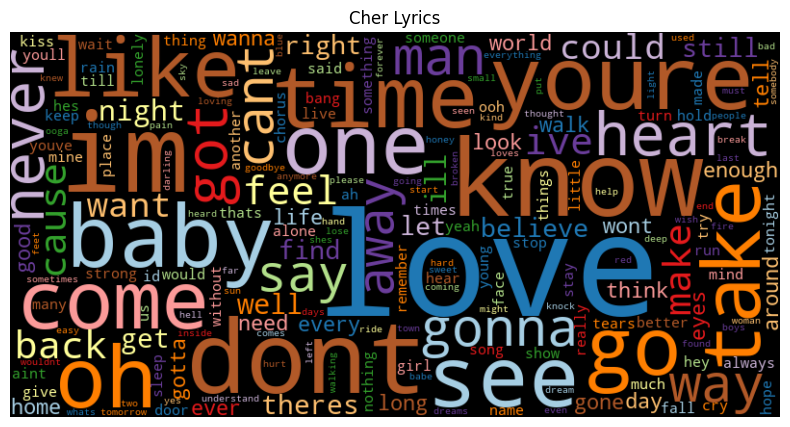

Robyn Lyrics Wordcloud:


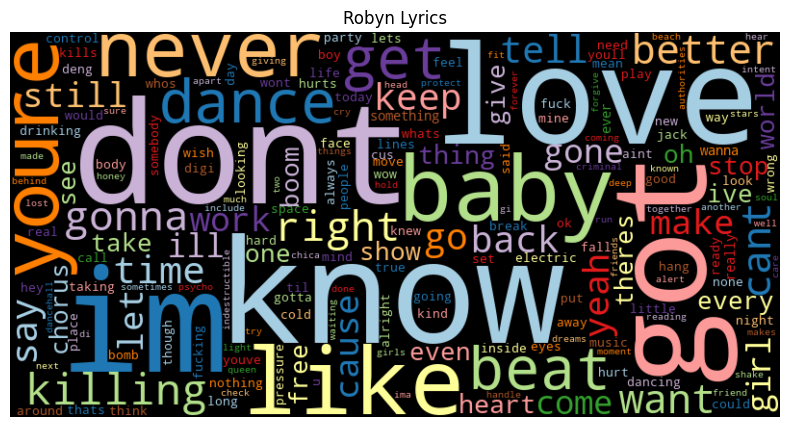

Cher Twitter Wordcloud:


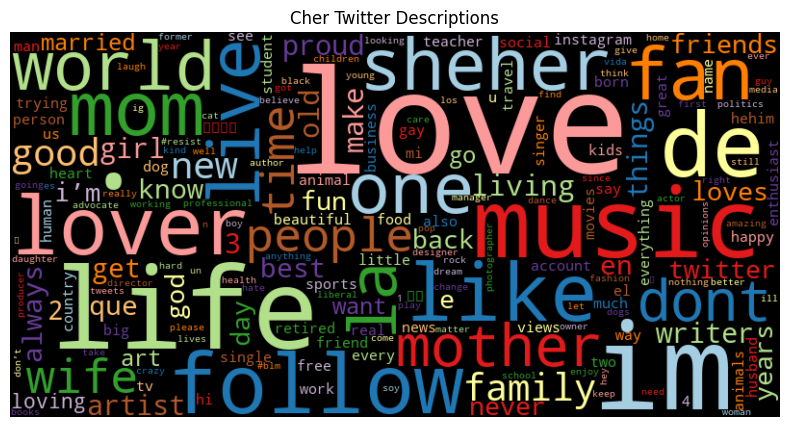

Robyn Twitter Wordcloud:


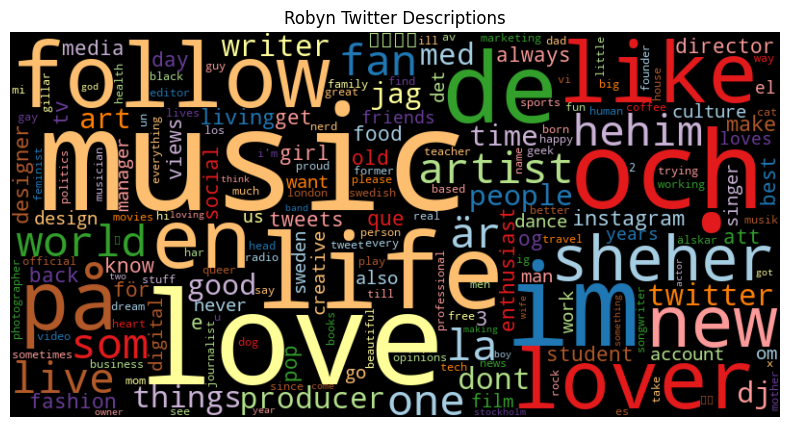

In [15]:
###

# Import necessary libraries
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter

# Define the wordcloud function
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    wc = WordCloud(width=800, height=400, 
                   background_color="black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # Convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # Filter stopwords in frequency counter
    if stopwords is not None:
        counter = {token: freq for (token, freq) in counter.items() 
                   if token not in stopwords}
    wc.generate_from_frequencies(counter)
    
    # Plot the wordcloud
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Define function to count words
def count_words(df, column='tokens', preprocess=None, min_freq=2):
    # Process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # Create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # Transform counter into DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)


# `lyrics_data` is DataFrame with Cher and Robyn lyrics
# `twitter_data` is DataFrame with Twitter descriptions for Cher and Robyn

# Count word frequencies for Cher's lyrics
cher_lyrics_freq = count_words(lyrics_data[lyrics_data['artist'] == 'cher'], column='tokens', min_freq=5)

# Count word frequencies for Robyn's lyrics
robyn_lyrics_freq = count_words(lyrics_data[lyrics_data['artist'] == 'robyn'], column='tokens', min_freq=5)

# Count word frequencies for Cher's Twitter descriptions
cher_twitter_freq = count_words(twitter_data[twitter_data['artist'] == 'cher'], column='tokens', min_freq=5)

# Count word frequencies for Robyn's Twitter descriptions
robyn_twitter_freq = count_words(twitter_data[twitter_data['artist'] == 'robyn'], column='tokens', min_freq=5)

# Generate wordclouds
print("Cher Lyrics Wordcloud:")
wordcloud(cher_lyrics_freq['freq'], title="Cher Lyrics")

print("Robyn Lyrics Wordcloud:")
wordcloud(robyn_lyrics_freq['freq'], title="Robyn Lyrics")

print("Cher Twitter Wordcloud:")
wordcloud(cher_twitter_freq['freq'], title="Cher Twitter Descriptions")

print("Robyn Twitter Wordcloud:")
wordcloud(robyn_twitter_freq['freq'], title="Robyn Twitter Descriptions")


Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: On the cher lyrics wordscloud, words such as love, baby, dont, know, and you'ar are most frequent. The emotional words such as heart, feel, believe, etc. were also present. On the Robyn lyrics, the most frequent words were themed love, baby, dont, and know. The lifestyle reflecting words such as dance, beat and get were present. 

We can observe that Cher lyrics were focused towards emotional and realtionships sentiment whereas Robyn's were focused on modern lifestyle.

The world cloud of Cher twitter inlcuded words as fan, love, life, mother and music. The other workds bonding the emotion and relationship as wife, family, mom, and mother. On the Robyn twitter wordcloud, there are words such as music, love, life, lover, follow, etc. The words such as love, like, lover, music higlihts the emotinal relationship in the Robyn twitter. 

The twitter descpriton of Cher tell us about the fanbase connecting to the emtional personal family relationships whereas Robyn twitter fan base is focused on the emotional interpersonal relationship. 